# Model Evaluation 

## Set Up

In [ ]:
import joblib
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

### Load Model 

In [ ]:

grid_search = joblib.load("vehicle_rf_model.pkl")

### Load Test Train Split 

In [3]:


with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print("Train/test sets loaded successfully.")

Train/test sets loaded successfully.


## Run Model 

In [5]:

y_pred_log = grid_search.predict(X_test)



## Convert Log Price 

In [6]:

y_pred_price = np.expm1(y_pred_log)
y_test_price = np.expm1(y_test)   # actual prices
residuals_price = y_test_price - y_pred_price


## Evaluating Residuals 

In [7]:

rmse_price = mean_squared_error(y_test_price, y_pred_price, squared=False)
mae_price = mean_absolute_error(y_test_price, y_pred_price)
r2_price = r2_score(y_test_price, y_pred_price)

print(f"RMSE (£): {rmse_price:,.2f}")
print(f"MAE (£): {mae_price:,.2f}")
print(f"R²: {r2_price:.2f}")


RMSE (£): 1,427.46
MAE (£): 845.95
R²: 0.90


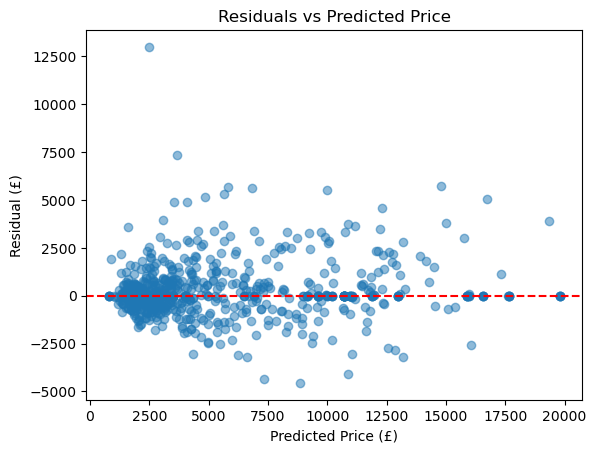

In [8]:


plt.scatter(y_pred_price, residuals_price, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price (£)')
plt.ylabel('Residual (£)')
plt.title('Residuals vs Predicted Price')
plt.show()


## Permutation Importance

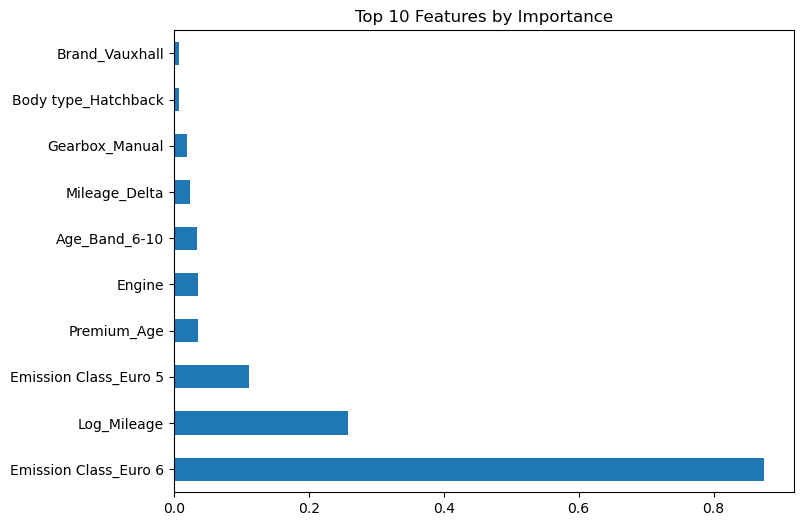

In [11]:


perm = permutation_importance(grid_search, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='r2')
perm_importance = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
perm_importance.head(10).plot(kind='barh', figsize=(8,6), title='Top 10 Features by Importance')
plt.show()


In [12]:
analysis_df = X_test.copy()
analysis_df['Actual Price (£)'] = y_test_price
analysis_df['Predicted Price (£)'] = y_pred_price
analysis_df['Residual (£)'] = residuals_price

undervalued = analysis_df[analysis_df['Residual (£)'] > 0].sort_values('Residual (£)', ascending=False)
overvalued = analysis_df[analysis_df['Residual (£)'] < 0].sort_values('Residual (£)')

print("Top 5 undervalued vehicles:\n", undervalued.head())
print("Top 5 overvalued vehicles:\n", overvalued.head())


Top 5 undervalued vehicles:
      Previous Owners  Engine  Doors  Seats  Has_Service_History  \
276                4     1.8    4.0    5.0                    0   
671                6     2.0    5.0    5.0                    0   
522                3     1.6    5.0    5.0                    1   
307                2     2.0    3.0    4.0                    0   
66                 3     2.0    5.0    5.0                    0   

     Mileage_per_Year  Log_Mileage  Mileage_Delta  Owners_per_Year  \
276          0.315789     1.791759        -170994         0.210526   
671       6153.846154    11.289782         -37000         0.461538   
522      12581.000000    10.133090           7162         1.500000   
307       7327.333333    11.096592         -15054         0.222222   
66        6666.666667    11.002100         -21000         0.333333   

     Is_Family_Car  ...  Model_Zafira Tourer  Usage_Level_Low  \
276              1  ...                False             True   
671              

## Undervalued Vehicles 

| Vehicle | Actual Price (£) | Predicted Price (£) | Residual (£) |
| ------- | ---------------- | ------------------- | ------------ |
| #276    | 15,499           | 2,503               | 12,996       |
| #671    | 10,994           | 3,663               | 7,331        |
| #522    | 20,499           | 14,791              | 5,708        |
| #307    | 11,496           | 5,816               | 5,680        |
| #66     | 12,494           | 6,847               | 5,647        |


**Interpretation:**

- These vehicles sold for much more than the model expected.

**Possible reasons:**

- rare model, low mileage, highly desirable brand/engine, or market timing.

**Actionable:**

- Consider highlighting these cars in listings or prioritizing them for marketing.

- Use these residuals to calibrate pricing strategies as model underestimated.

## Overvalued Vehicles 

| Vehicle | Actual Price (£) | Predicted Price (£) | Residual (£) |
| ------- | ---------------- | ------------------- | ------------ |
| #33     | 4,299            | 8,854               | -4,555       |
| #479    | 2,998            | 7,328               | -4,330       |
| #9      | 6,792            | 10,866              | -4,074       |
| #35     | 3,399            | 6,620               | -3,221       |
| #520    | 9,994            | 13,198              | -3,204       |


**Interpretation:**

- These vehicles sold for much less than predicted.

**Possible reasons:**

- high mileage, poor condition, less desirable features, or mispricing.

**Actionable:**

- Avoid overpricing these in future listings.

- Analyse why these cars underperformed (service history, owners, mileage, or model popularity).

## How to use these insights

**Pricing Strategy:**

Adjust listing prices for over/under-performing segments using residuals.

**Example:**

add a buffer for undervalued cars, discount overvalued ones.

**Marketing Priorities:**

Highlight features that the model underestimates (e.g., rare trims, popular engines).

**Inventory Planning:**

Acquire vehicles that tend to outperform predictions — low mileage, desirable engine, Euro 5/6 class.

Avoid over-investing in vehicles that consistently underperform.

**Model Calibration:**

Large residuals indicate where the model is under- or over-predicting.
Could be used to refine feature engineering or create segment-specific models.